# 导入包

In [2]:
# coding: utf-8

#csv导入为dataframe的包
import pandas as pd
from pandas import Series, DataFrame
#导入时间和复制的包
import datetime,time
import copy

##解决在jupyter中画图不显示的问题
get_ipython().magic(u'matplotlib inline')
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
#解决中文编码的问题
import sys
defaultencoding = 'utf-8'
if sys.getdefaultencoding() != defaultencoding:
    reload(sys)
    sys.setdefaultencoding(defaultencoding)


import this

# 导入数据

In [2]:
data = pd.read_csv("K:/16.12.6-python/data/9.csv", low_memory = False)

In [4]:
#1、此数据中有部分数据重复，需删除；
num=[]
timestamp=data["TIMESTAMP"]
for i in range(len(data.index)):
    if timestamp[i]==timestamp[0]:#获取数据中与第一个时间戳数值相同点的位置
        num.append(i)
num

[0, 671884]

In [5]:
data=data.drop(range(num[1],len(data.index)),axis=0)#删掉重复的数据，只取不重复的数据

In [7]:
#2、数据需要按时间重新排序
data=data.sort(["TIMESTAMP"],ascending=[1])#按时间戳进行排序，ascending=1代表递增，0代表递减

# 提取部分数据并复制两份原数据

In [9]:
timestamp=data["TIMESTAMP"]
terminalnum=data["终端消息命令号"]
mileage=data["里程"]
longitude=data["经度"]
latitude=data["纬度"]
speed1=data["速度"]
altitude=data["高度"]
pathangle=data["方向角"]
accelerationpedal=data["油门踏板位置"]
brakepedal=data["制动踏板位置"]
motor=data["电机转速"]
totalmileage=data["总里程"]

data2 = data
data3 = data

# 分离两种传感器值

In [10]:
#用终端消息命令号来识别，不为0则为传感器1，为0则是传感器2
#data2.drop([2,3],axis=0)#AXIS=0删除行。AXIS=1删除列
num1=[]
num2=[]
for i in range(len(terminalnum)):
    if terminalnum[i]!=0:
        num1.append(i)
    else:
        num2.append(i)
data2=data2.drop(num1,axis=0)
data3=data3.drop(num2,axis=0)

In [11]:
#将分离出的传感器写入文件
data2.to_csv("K:/16.12.6-python/data/clear1.csv",index=False)#index=false表示去掉列头
data3.to_csv("K:/16.12.6-python/data/clear2.csv",index=False)

# 分离出时间差较大的数据块并存储

In [12]:
#由于排序后索引行号仍与以前相同，data2需重新读入以校正索引行号
data2 = pd.read_csv("K:/16.12.6-python/data/clear1.csv", low_memory = False)

In [14]:
timestamp=data2["TIMESTAMP"]
date=data2["DATIME_RX"]

In [16]:
timestamp=data2["TIMESTAMP"]
date=data2["DATIME_RX"]
timedif=[]
timedifnum=[]
daterecord=[]

for i in range(len(timestamp)-1):
    if((timestamp[i+1]-timestamp[i])>1800000):  #找出时间差大于30min的点，并记录时间
        timedifnum.append(i)
        timedif.append(timestamp[i+1]-timestamp[i])
        daterecord.append(date[i])
len(timedif)

35

In [17]:
timedifnum.insert(0,0)
timedifnum.insert(len(timedifnum),len(timestamp))

In [19]:
for i in range(len(timedifnum)-1):
    addr="K:/16.12.6-python/data/data/"+str(i)+".csv"
    data2[timedifnum[i]+1:timedifnum[i+1]+1].to_csv(addr,index=False)

# 读取数据并画图

In [108]:
data3 = pd.read_csv("K:/16.12.6-python/data/data/0.csv", low_memory = False)

In [109]:
time=data3["TIMESTAMP"]
time2=[]
motor=data3["电机转速"]
motor2=[]
for i in range(len(time)):
    time2.append((time[i]-time[0])/60000.0)#把时间化为分钟

In [110]:
where_are_nan = np.isnan(data3["电机转速"])

In [111]:
time3=[]
for i in range(len(where_are_nan)):
    if not where_are_nan[i]:
        time3.append(time2[i])
        motor2.append(motor[i])

In [114]:
len(motor2)

7494

In [115]:
len(time3)

7494

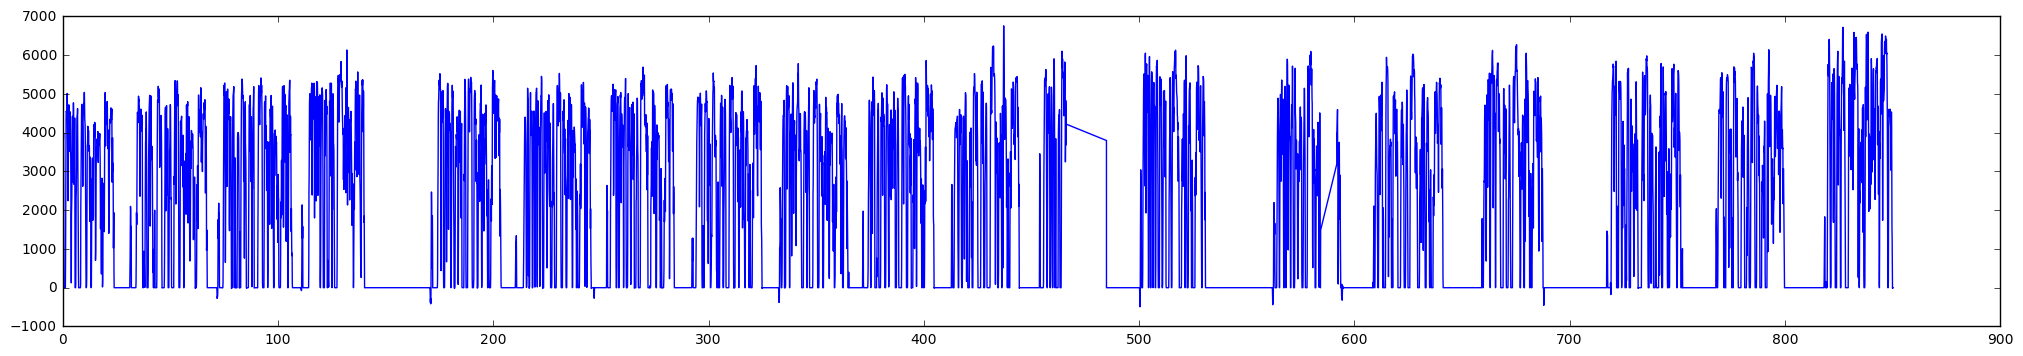

In [136]:
plt.figure(figsize=(25,4))
plt.plot(time3,motor2)

# 通过电机转速划分trip

In [133]:
startnum=0
endnum=0
triprecord=[0]
for i in range(len(time3)-1):
    if(motor2[i]<10 and startnum==0):
        startnum=i
    elif(motor2[i]<10 and startnum!=0):
        endnum=i
        if(motor2[i+1]>10):
            if((time3[endnum]-time3[startnum])>10):
                triprecord.append(startnum)
                triprecord.append(endnum)
            else:
                startnum=0
                endnum=0           
    else:
        startnum=0
        endnum=0
triprecord.append(len(time3)-1)   
        

In [135]:
triptime=[]
for i in triprecord:
    triptime.append(time3[i])
triptime

[0.0,
 140.23356666666666,
 171.06251666666665,
 484.85961666666668,
 500.52379999999999,
 530.85668333333331,
 562.34945000000005,
 594.67976666666664,
 608.59508333333338,
 641.25698333333332,
 659.08851666666669,
 687.75168333333329,
 717.16444999999999,
 752.49338333333333,
 767.90790000000004,
 799.73770000000002,
 818.15290000000005,
 850.23246666666671]

In [72]:
"""
#新建数据框的方法
df={"num":timedifnum,"dif":timedif,"date":daterecord}
df1=pd.DataFrame(data=df)
df1
"""

In [111]:
"""
#时间函数（timestamp->UTC时间）
def timestamp2string(timeStamp):  
    try:  
        d = datetime.datetime.fromtimestamp(timeStamp/1000.0)  
        str1 = d.strftime("%Y-%m-%d %H:%M:%S.%f")  
        # 2015-08-28 16:43:37.283000'  
        return str1  
    except Exception as e:  
        print e  
        return ''
    
#调用方式（13位）    
timestamp2string(timestamp[290891])
"""